In [1]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, initializers
from keras.layers import *
from keras.models import * 
from keras.utils import *
from keras.preprocessing import image
import tensorflow as tf
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/MYCT_pics_updated.zip"

Streaming output truncated to the last 5000 lines.
  inflating: MYCT_pics_updated/train/genuine/0098v02.png  
  inflating: MYCT_pics_updated/train/genuine/0098v05.png  
  inflating: MYCT_pics_updated/train/genuine/0099v06.png  
  inflating: MYCT_pics_updated/train/genuine/0099v08.png  
  inflating: MYCT_pics_updated/train/genuine/0098v04.png  
  inflating: MYCT_pics_updated/train/genuine/0098v06.png  
  inflating: MYCT_pics_updated/train/genuine/0099v00.png  
  inflating: MYCT_pics_updated/train/genuine/0099v02.png  
  inflating: MYCT_pics_updated/train/genuine/0099v07.png  
  inflating: MYCT_pics_updated/train/genuine/0098v11.png  
  inflating: MYCT_pics_updated/train/genuine/0099v05.png  
  inflating: MYCT_pics_updated/train/genuine/0099v10.png  
  inflating: MYCT_pics_updated/train/genuine/0098v01.png  
  inflating: MYCT_pics_updated/train/genuine/0098v10.png  
  inflating: MYCT_pics_updated/train/genuine/0099v09.png  
  inflating: MYCT_pics_updated/train/genuine/0098v09.png  
  inf

In [4]:
train_dir="/content/MYCT_pics_updated/train/"
train_csv="/content/MYCT_pics_updated/train_data.csv"
test_csv="/content/MYCT_pics_updated/test_data.csv"
test_dir="/content/MYCT_pics_updated/test/"

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

In [ ]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

In [ ]:
img = plt.imread(train_dir+"/"+(df_train.iat[1,0]))
plt.imshow(img)

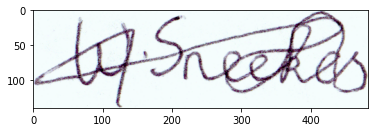

In [ ]:
img = plt.imread(train_dir+"/"+df_train.iat[1,1])
plt.imshow(img)

In [6]:
def Residual_Unit(input_tensor, nb_of_input_channels, max_dilation, number_of_units):
    
  for i in range(number_of_units):
    x1 = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)
  
    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)
    x = Conv2D(nb_of_input_channels, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_tensor])

    input_tensor = x
  
  return x

In [7]:
def Shifter_Unit(input_tensor, nb_of_input_channels, max_dilation):
    x1 = Conv2D(nb_of_input_channels*4, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)

    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = MaxPool2D(pool_size=(2,2))(temp)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)

    x = Conv2D(nb_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    return x

In [8]:
train_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale= 1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32,32),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32,32),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )

Found 2400 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'forged': 0, 'genuine': 1}

In [11]:
def Network32(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=3)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(64, activation='relu')(x)
  x = Dense(nb_class, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics = [tf.keras.metrics.AUC(),"accuracy"])

  return model

In [12]:
sig32_model = Network32(input_shape = (32, 32, 1), nb_class = 2 , depth = 5)
sig32_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   4640        batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_32_MYCT.hdf5",
    monitor='val_auc',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [14]:
sig32_hist = sig32_model.fit(x=train_generator,
                              validation_data=test_generator,
                              epochs = 50,
                              callbacks=[model_checkpoint_callback],
                              shuffle=False
                              )

Epoch 1/50
75/75 [==============================] - 174s 2s/step - loss: 0.7181 - auc: 0.4819 - accuracy: 0.4928 - val_loss: 1.7796 - val_auc: 0.5000 - val_accuracy: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_32_MYCT.hdf5
Epoch 2/50
75/75 [==============================] - 137s 2s/step - loss: 0.6492 - auc: 0.6708 - accuracy: 0.6302 - val_loss: 2.5750 - val_auc: 0.5000 - val_accuracy: 0.5000

Epoch 00002: val_auc did not improve from 0.50000
Epoch 3/50
75/75 [==============================] - 137s 2s/step - loss: 0.5945 - auc: 0.8117 - accuracy: 0.7324 - val_loss: 3.1369 - val_auc: 0.5000 - val_accuracy: 0.5000

Epoch 00003: val_auc did not improve from 0.50000
Epoch 4/50
75/75 [==============================] - 137s 2s/step - loss: 0.5367 - auc: 0.8756 - accuracy: 0.7988 - val_loss: 3.1807 - val_auc: 0.5000 - val_accuracy: 0.5000

Epoch 00004: val_auc did not improve from 0.50000
E

KeyboardInterrupt: ignored

In [15]:
sig32_model = load_model("/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_32_MYCT.hdf5")

In [16]:
y_actual2 , y_test2 = [],[]

In [17]:
for i in os.listdir("/content/MYCT_pics_updated/val/genuine/"):
    img=image.load_img("/content/MYCT_pics_updated/val/genuine/"+i,target_size=(32,32),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig32_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(1)

In [18]:
for i in os.listdir("/content/MYCT_pics_updated/val/forged/"):
    img=image.load_img("/content/MYCT_pics_updated/val/forged/"+i,target_size=(32,32),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig32_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(0)

In [19]:
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

In [20]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       0.45      0.46      0.45       100
           1       0.44      0.43      0.44       100

    accuracy                           0.45       200
   macro avg       0.44      0.45      0.44       200
weighted avg       0.44      0.45      0.44       200



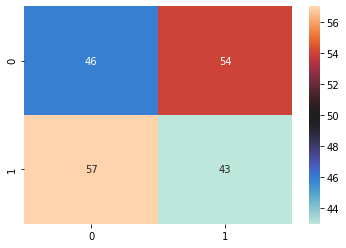

In [21]:
sns.heatmap(cn2,cmap="icefire",annot=True)

In [22]:
acc = sig32_hist.history['accuracy']
val_acc = sig32_hist.history['val_accuracy']

auc = sig32_hist.history['auc']
val_auc = sig32_hist.history['val_auc']
epochs_range = range(50)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='Training auc')
plt.plot(epochs_range, val_auc, label='Validation auc')
plt.legend(loc='upper right')
plt.title('Training and Validation auc')
plt.show()

NameError: ignored

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (64,64),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (64,64),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )

Found 1649 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'FORGED': 0, 'GENUINE': 1}

In [ ]:
def Network64(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=4, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=4)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=3)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(64, activation='relu')(x)
  x = Dense(nb_class, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics = [tf.keras.metrics.AUC(),"accuracy"])

  return model

In [ ]:
sig64_model = Network64(input_shape = (64, 64, 1), nb_class = 2 , depth = 5)
sig64_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4640        batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_64_MYCT.hdf5",
    monitor='val_auc',
    verbose = 1,
    mode='max',
    save_best_only=True)

In [ ]:
sig64_hist = sig64_model.fit(x=train_generator,
                              validation_data=test_generator,
                              epochs = 50,
                              callbacks=[model_checkpoint_callback]
                              )

Epoch 1/50
52/52 [==============================] - 57s 303ms/step - loss: 0.9122 - auc: 0.7069 - accuracy: 0.6398 - val_loss: 0.6980 - val_auc: 0.4927 - val_accuracy: 0.5040

Epoch 00001: val_auc improved from -inf to 0.49269, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_64.hdf5
Epoch 2/50
52/52 [==============================] - 13s 254ms/step - loss: 0.2786 - auc: 0.9536 - accuracy: 0.9000 - val_loss: 1.3573 - val_auc: 0.5040 - val_accuracy: 0.5040

Epoch 00002: val_auc improved from 0.49269 to 0.50400, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_64.hdf5
Epoch 3/50
52/52 [==============================] - 13s 257ms/step - loss: 0.1690 - auc: 0.9820 - accuracy: 0.9345 - val_loss: 1.9183 - val_auc: 0.5040 - val_accuracy: 0.5040

Epoch 00003: val_auc did not improve from 0.50400
Epoch 4/50
52/52 [==============================] - 14s 260ms/step - loss: 0.1591 - auc: 0.9847 - accuracy: 0.9368 - val_lo

In [ ]:
sig64_model = load_model('/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_64_MYCT.hdf5')

In [ ]:
y_actual2 , y_test2 = [],[]

In [ ]:
for i in os.listdir("/content/MYCT_pics_updated/val/GENUINE/"):
    img=image.load_img("/content/MYCT_pics_updated/val/GENUINE/"+i,target_size=(64,64),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig64_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(1)

In [ ]:
for i in os.listdir("/content/MYCT_pics_updated/val/FORGED/"):
    img=image.load_img("/content/MYCT_pics_updated/val/FORGED/"+i,target_size=(64,64),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig64_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(0)

In [ ]:
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

In [ ]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       252

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



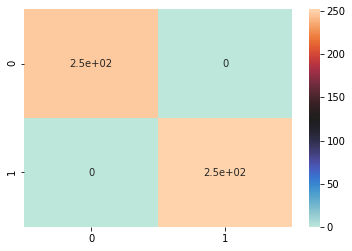

In [ ]:
sns.heatmap(cn2,cmap="icefire",annot=True)

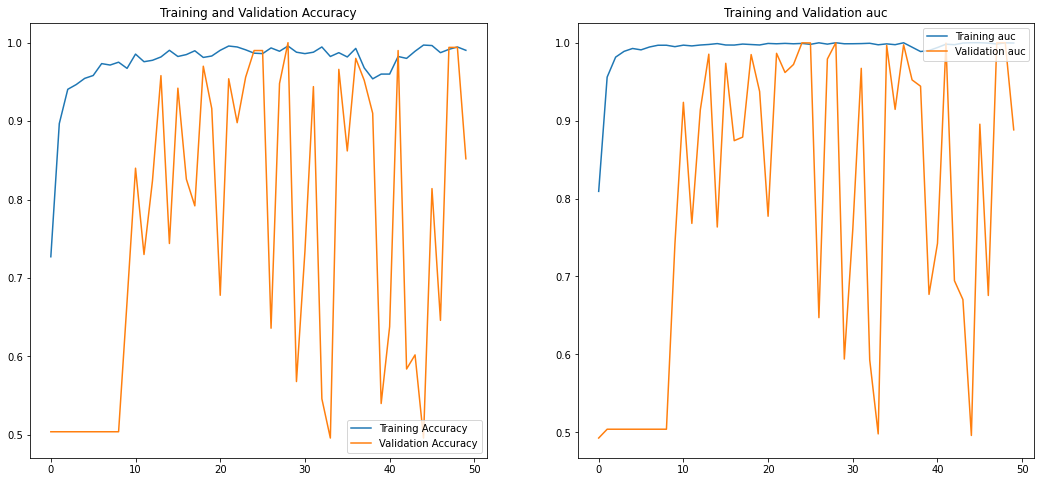

In [ ]:
acc = sig64_hist.history['accuracy']
val_acc = sig64_hist.history['val_accuracy']

auc = sig64_hist.history['auc']
val_auc = sig64_hist.history['val_auc']
epochs_range = range(50)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='Training auc')
plt.plot(epochs_range, val_auc, label='Validation auc')
plt.legend(loc='upper right')
plt.title('Training and Validation auc')
plt.show()

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (128,128),
    color_mode='grayscale',
    batch_size = 32,
    class_mode = "categorical"
    )

Found 3200 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'FORGED': 0, 'GENUINE': 1}

In [ ]:
def Network128(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=5)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=4)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=3)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  x = Dense(nb_class, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01) , metrics = [tf.keras.metrics.AUC(),"accuracy"])

  return model

In [ ]:
sig128_model = Network128(input_shape = (128, 128, 1), nb_class = 2 , depth = 5)
sig128_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 16) 416         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 128, 128, 16) 64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 64, 32)   4640        batch_normalization_52[0][0]     
____________________________________________________________________________________________

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_128_MYCT.hdf5",
    monitor='val_auc',
    verbose = 1,
    mode='max',
    save_best_only=True)

In [ ]:
sig128_hist = sig128_model.fit(x=train_generator,
                              validation_data=test_generator,
                              epochs = 50,
                              callbacks=[model_checkpoint_callback]
                              )

Epoch 1/50
100/100 [==============================] - 186s 2s/step - loss: 0.8969 - auc_1: 0.5264 - accuracy: 0.5225 - val_loss: 0.8463 - val_auc_1: 0.5000 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 167s 2s/step - loss: 0.6866 - auc_1: 0.5611 - accuracy: 0.5413 - val_loss: 0.6940 - val_auc_1: 0.5000 - val_accuracy: 0.5000
Epoch 3/50
100/100 [==============================] - 167s 2s/step - loss: 0.6867 - auc_1: 0.5514 - accuracy: 0.5242 - val_loss: 0.6949 - val_auc_1: 0.5000 - val_accuracy: 0.5000
Epoch 4/50
100/100 [==============================] - 167s 2s/step - loss: 0.6649 - auc_1: 0.6310 - accuracy: 0.6089 - val_loss: 0.6950 - val_auc_1: 0.4818 - val_accuracy: 0.5000
Epoch 5/50
 41/100 [===========>..................] - ETA: 1:12 - loss: 0.6495 - auc_1: 0.6735 - accuracy: 0.6444

KeyboardInterrupt: ignored

In [ ]:
sig128_model = load_model("/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_128_MYCT.hdf5")

In [ ]:
y_actual2 , y_test2 = [],[]
for i in os.listdir("/content/MYCT_pics_updated/val/GENUINE/"):
    img=image.load_img("/content/MYCT_pics_updated/val/GENUINE/"+i,target_size=(128,128),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig128_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(1)
for i in os.listdir("/content/MYCT_pics_updated/val/FORGED/"):
    img=image.load_img("/content/MYCT_pics_updated/val/FORGED/"+i,target_size=(128,128),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig128_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(0)
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

In [ ]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       252

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



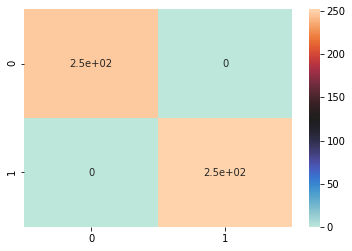

In [ ]:
sns.heatmap(cn2,cmap="icefire",annot=True, fmt=".1f")

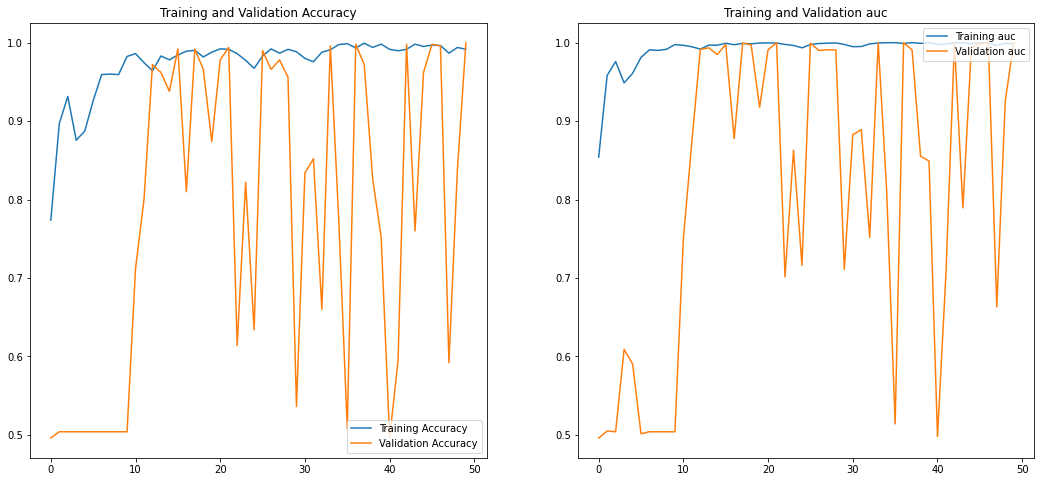

In [ ]:
acc = sig128_hist.history['accuracy']
val_acc = sig128_hist.history['val_accuracy']

auc = sig128_hist.history['auc']
val_auc = sig128_hist.history['val_auc']
epochs_range = range(50)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='Training auc')
plt.plot(epochs_range, val_auc, label='Validation auc')
plt.legend(loc='upper right')
plt.title('Training and Validation auc')
plt.show()

In [8]:
train_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale= 1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256,256),
    color_mode='grayscale',
    batch_size = 8,
    class_mode = "categorical"
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    color_mode='grayscale',
    batch_size = 8,
    class_mode = "categorical"
    )

Found 2400 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'forged': 0, 'genuine': 1}

In [11]:
def Network256(input_shape, nb_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=6, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=32, max_dilation=6)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=5, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=64, max_dilation=5)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=4, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=128, max_dilation=4)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=3, number_of_units=depth)
  x = Shifter_Unit(input_tensor=x, nb_of_input_channels=256, max_dilation=3)

  x = Residual_Unit(input_tensor=x, nb_of_input_channels=512, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(64, activation='relu')(x)
  x = Dense(nb_class, activation= 'softmax')(x)

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics = [tf.keras.metrics.AUC(),"accuracy"])

  return model

In [12]:
sig256_model = Network256(input_shape = (256, 256, 1), nb_class = 2 , depth = 5)
sig256_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4640        batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_256_MYCT.hdf5",
    monitor='val_auc',
    verbose = 1,
    mode='max',
    save_best_only=True)

In [ ]:
sig256_hist = sig256_model.fit(x=train_generator,
                              validation_data=test_generator,
                              epochs = 50,
                              callbacks=[model_checkpoint_callback]
                              )

Epoch 1/50
300/300 [==============================] - 634s 2s/step - loss: 0.7381 - auc: 0.5330 - accuracy: 0.5158 - val_loss: 2.8825 - val_auc: 0.5000 - val_accuracy: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_256_MYCT.hdf5
Epoch 2/50
300/300 [==============================] - 575s 2s/step - loss: 0.7104 - auc: 0.5867 - accuracy: 0.5674 - val_loss: 0.7050 - val_auc: 0.5147 - val_accuracy: 0.5058

Epoch 00002: val_auc improved from 0.50000 to 0.51474, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_256_MYCT.hdf5
Epoch 3/50
300/300 [==============================] - 575s 2s/step - loss: 0.7185 - auc: 0.5334 - accuracy: 0.5201 - val_loss: 0.7432 - val_auc: 0.5651 - val_accuracy: 0.5467

Epoch 00003: val_auc improved from 0.51474 to 0.56511, saving model to /content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_256_MYCT.hdf5
Epoc

In [ ]:
sig256_model = load_model("/content/drive/MyDrive/Tanweer Internships & Jobs/Rashmi Sir/best_model_256_MYCT.hdf5")

In [ ]:
y_actual2 , y_test2 = [],[]
for i in os.listdir("/content/MYCT_pics_updated/val/GENUINE/"):
    img=image.load_img("/content/MYCT_pics_updated/val/GENUINE/"+i,target_size=(256,256),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig256_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(1)
for i in os.listdir("/content/MYCT_pics_updated/val/FORGED/"):
    img=image.load_img("/content/MYCT_pics_updated/val/FORGED/"+i,target_size=(256,256),color_mode='grayscale')
    img2=image.img_to_array(img)
    img3=img2/255.0
    img4=np.expand_dims(img3,axis=0)
    pred=sig256_model.predict(img4)
    pred1 = np.argmax(pred,axis=-1)
    y_test2.append(pred1[0])
    y_actual2.append(0)
y_actual2=np.array(y_actual2)
y_test2=np.array(y_test2)

In [ ]:
cn2=confusion_matrix(y_actual2,y_test2)
print(metrics.classification_report(y_actual2,y_test2))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       248
           1       0.95      1.00      0.98       252

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



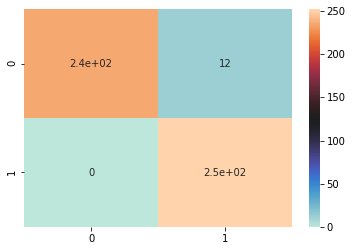

In [ ]:
sns.heatmap(cn2,cmap="icefire",annot=True)

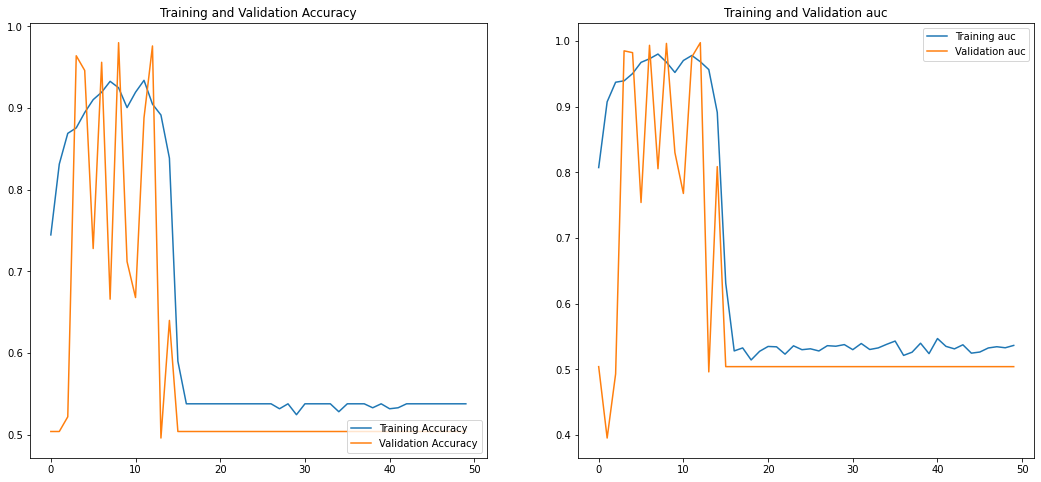

In [ ]:
acc = sig256_hist.history['accuracy']
val_acc = sig256_hist.history['val_accuracy']

auc = sig256_hist.history['auc']
val_auc = sig256_hist.history['val_auc']
epochs_range = range(50)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='Training auc')
plt.plot(epochs_range, val_auc, label='Validation auc')
plt.legend(loc='upper right')
plt.title('Training and Validation auc')
plt.show()